# Проект: Интернет-магазин «В один клик»

## Описание и цель проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Постановка задачи:
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install shap  -q

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap, phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
#from sklearn.model_selection import RandomizedSearchCV

#from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
plt.rcParams["figure.figsize"] = (10,5)
pd.set_option('display.max_rows', None)  # Отображать все строки
pd.set_option('display.max_columns', None)  # Отображать все столбцы

## Загрузка данных

Файл market_file.csv

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv') #чтение файла /market_file.csv  
display (market_file.head()) #вывод первых пяти строк
print (market_file.info()) #вывод общей информации о DataFrame

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Данные в таблице market_file соответствуют описанию, нулевых значений нет, типы данных верные (возможно, тип данных столбца "Разрешить сообщать" в последующем будет заменен на bool).

Файл market_money.csv

In [4]:
market_money = pd.read_csv('/datasets/market_money.csv') #чтение файла /market_money.csv  
display (market_money.head(5)) #вывод первых пяти строк
print (market_money.info()) #вывод общей информации о DataFrame

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


Данные в таблице market_money соответствуют описанию, нулевых значений нет, типы данных верные.

Файл /datasets/market_time.csv

In [5]:
market_time = pd.read_csv('/datasets/market_time.csv') #чтение файла /market_time.csv  
display (market_time.head()) #вывод первых пяти строк
print (market_time.info()) #вывод общей информации о DataFrame

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


Данные в таблице market_money соответствуют описанию, нулевых значений нет, типы данных верные.

Файл /datasets/money.csv

In [6]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',') #чтение файла /money.csv  
display (money.head()) #вывод первых пяти строк
print (money.info()) #вывод общей информации о DataFrame

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


Данные в таблице market_money соответствуют описанию, нулевых значений нет.

### Промежуточный вывод
На данном этапе мы лишь загрузили данные и "познакомились" с ними - данные в таблице соответствуют описанию, нулевых значений нет, типы данных верные. Проведем предобработку данных.

## Предобработка данных

В соответствии с ТЗ названия столбцов можно оставить кириллическими, но приведем их к единому формату - заменим " " (пробел) на "_" (нижнее подчеркивание) в таблице market_file, а также заменим строчную букву на заглавную в названии столбца таблицы market_time (проверим внесенные изменения, отобразив информацию об указанных таблицах).

In [7]:
market_file.columns = market_file.columns.str.replace(' ', '_', regex=False)
market_time.columns = market_time.columns.str.replace('минут', 'Минут', regex=False)
print (market_file.info()) #вывод общей информации о DataFrame
print (market_time.info()) #вывод общей информации о DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Проверим наличие дубликатов.

In [8]:
print('Количество дубликатов в таблице market_file:', market_file.duplicated().sum())
print('Количество дубликатов в таблице market_money:', market_money.duplicated().sum())
print('Количество дубликатов в таблице market_time:', market_time.duplicated().sum())
print('Количество дубликатов в таблице money:', money.duplicated().sum())


Количество дубликатов в таблице market_file: 0
Количество дубликатов в таблице market_money: 0
Количество дубликатов в таблице market_time: 0
Количество дубликатов в таблице money: 0


Явных дубликатов нет, попробуем выявить неявные дубликаты.
Для этого:
 - проверим число уникальных id в таблице market_file
 - выведем уникальные значения категориальных признаков в таблице market_file (Покупательская_активность, Тип_сервиса, Разрешить_сообщать, Популярная_категория), если количество значений немного, можно проверить на наличие опечаток
 - выведем уникальные значения категориального признака в таблице market_money (Период), если значений немного, можно проверить на наличие опечаток
  - выведем уникальные значения категориального признака в таблице market_time (Период), если значений немного, можно проверить на наличие опечаток
  - проверим число уникальных id в таблице money


In [9]:
print ('Количество id в таблице market_file:', market_file['id'].nunique())
print ('Значения столбца "Покупательская_активность" в таблице market_file:', market_file['Покупательская_активность'].unique())
print ('Значения столбца "Тип_сервиса" в таблице market_file:', market_file['Тип_сервиса'].unique())
print ('Значения столбца "Разрешить_сообщать" в таблице market_file:', market_file['Разрешить_сообщать'].unique())
print ('Значения столбца "Популярная_категория" в таблице market_file:', market_file['Популярная_категория'].unique())
print ('Значения столбца "Период" в таблице market_money:', market_money['Период'].unique())
print ('Значения столбца "Период" в таблице market_time:', market_time['Период'].unique())
print ('Количество id в таблице money:', money['id'].nunique())



Количество id в таблице market_file: 1300
Значения столбца "Покупательская_активность" в таблице market_file: ['Снизилась' 'Прежний уровень']
Значения столбца "Тип_сервиса" в таблице market_file: ['премиум' 'стандартт' 'стандарт']
Значения столбца "Разрешить_сообщать" в таблице market_file: ['да' 'нет']
Значения столбца "Популярная_категория" в таблице market_file: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
Значения столбца "Период" в таблице market_money: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Значения столбца "Период" в таблице market_time: ['текущий_месяц' 'предыдцщий_месяц']
Количество id в таблице money: 1300


Результат проверки:
 - число уникальных id в таблицах market_file и money совпадает с количеством строк, соответственно, все id уникальны
 - в значениях столбца "Тип_сервиса" в таблице market_file есть опечатка (стандартт) - устраним ее
 - в значениях столбца "Популярная_категория" в таблице market_file есть опечатка (Косметика и аксесуары) - устраним ее
 - в значениях столбца "Период" в таблице market_time есть опечатка (предыдцщий_месяц) - устраним ее

In [10]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')
print ('Значения столбца "Тип_сервиса" в таблице market_file:', market_file['Тип_сервиса'].unique())

market_file['Популярная_категория'] = market_file['Популярная_категория'].replace('Косметика и аксесуары', 'Косметика и аксессуары')
print ('Значения столбца "Тип_сервиса" в таблице market_file:', market_file['Тип_сервиса'].unique())

market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
print ('Значения столбца "Период" в таблице market_money:', market_time['Период'].unique())


Значения столбца "Тип_сервиса" в таблице market_file: ['премиум' 'стандарт']
Значения столбца "Тип_сервиса" в таблице market_file: ['премиум' 'стандарт']
Значения столбца "Период" в таблице market_money: ['текущий_месяц' 'предыдущий_месяц']


Также проверим уникальность пар "id и Период" в таблицах market_money и market_time.

In [11]:
display(market_money[market_money[['id', 'Период']].duplicated(keep=False)])
market_time[market_time[['id', 'Период']].duplicated(keep=False)]

,id,Период,Выручка


,id,Период,Минут


Дубликатов пар "id и Период" в таблицах market_money и market_time не выявлено.

### Промежуточный вывод
На данном этапе выполнена предобработка данных, выявлены и устранены опечатки в значениях, а также изменены названия столбцов.

## Исследовательский анализ данных

### Анализ данных в таблице market_file

Построим графики для каждого признака. 
Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [12]:
market_file.describe()

info_market_file = market_file.drop(columns=['id']).describe().T
info_market_file['norm_min']=info_market_file['25%']-1.5*info_market_file['std']
info_market_file['norm_max']=info_market_file['75%']+1.5*info_market_file['std']
info_market_file

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.9,6.60,2.177779,6.422221
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.0,5.00,2.954698,5.045302
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.0,1079.00,30.715566,1180.784434
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.3,0.99,-0.204765,0.674765
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.0,6.00,-0.033026,6.033026
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.0,10.00,-1.957177,6.957177
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.0,9.00,0.067054,8.932946
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.0,20.00,-0.967189,16.967189


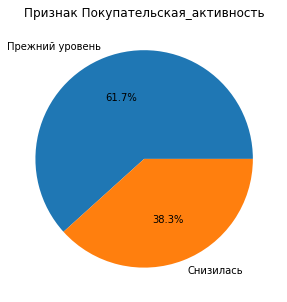

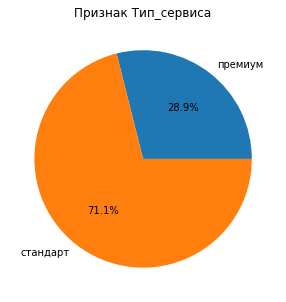

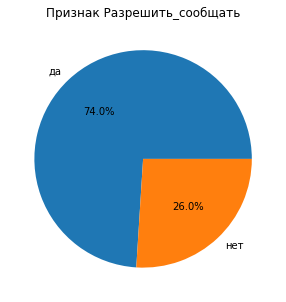

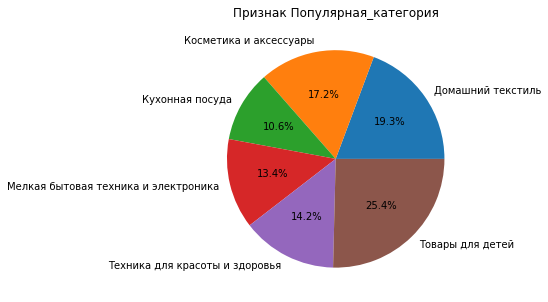

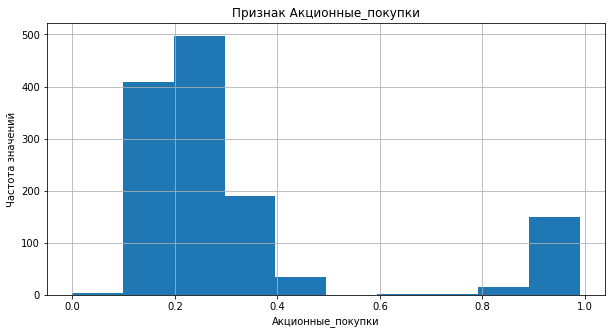

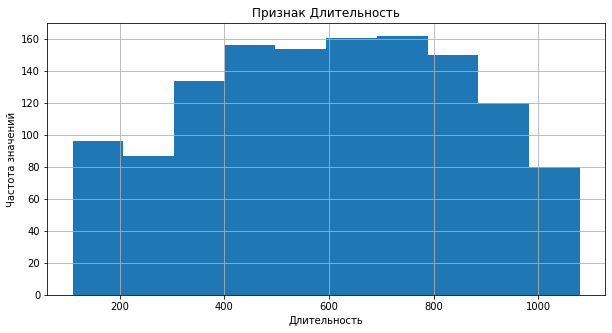

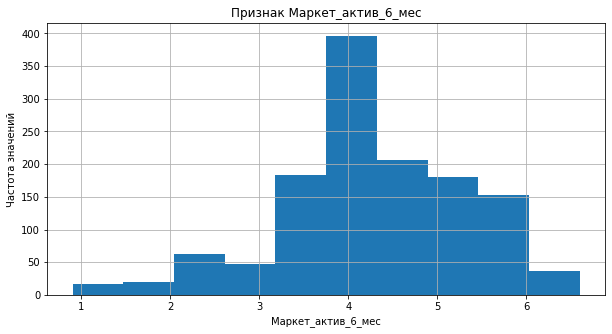

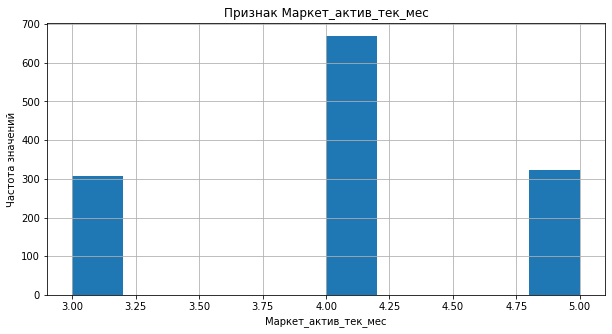

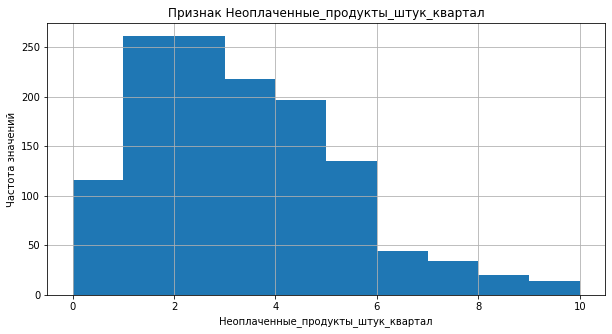

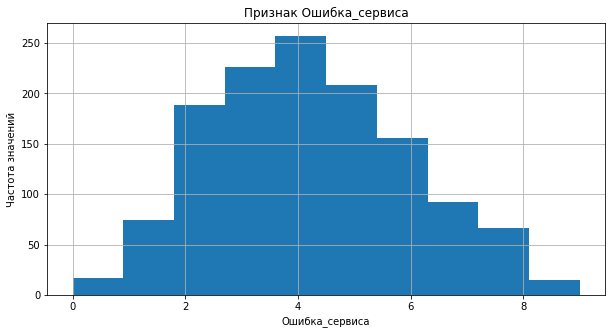

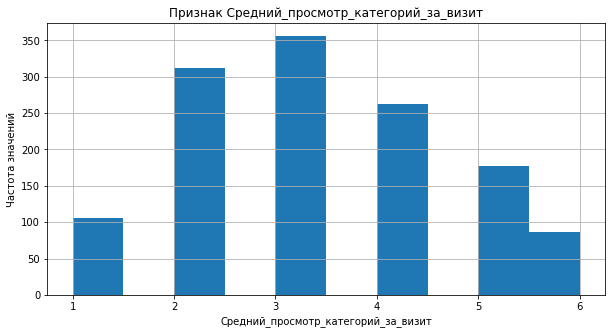

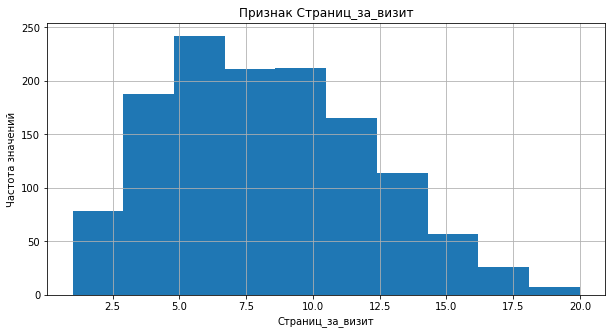

In [13]:
# определяем категориальные и количественные признаки
categorical_features = market_file.select_dtypes(include=['object']).columns
numerical_features = market_file.select_dtypes(include=['int64', 'float64']).columns.difference(['id'])

# построение графиков для категориальных признаков
for i, feature in enumerate(categorical_features):
    market_file.groupby(feature)[feature].count().plot.pie(autopct='%1.1f%%')
    plt.title(f'Признак {feature}')
    plt.ylabel('')
    plt.show() 

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(market_file[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  



По представленным графикам можно сделать следующие выводы о данных таблицы market_file:
 - выбросов в данных не наблюдается
 - распределение признака "акционные покупки" имеет два пика, вероятно, это связано с тем, что, в целом, покупателей можно разделить на две категории: тех, кто старается купит все по акции, и тех, кто не обращает внимание на акции (тогда процент акционных покупок меньше половины)
 - вероятно, признак "Маркет_актив_тек_мес" можно перевести в категориальный (например, низкая/средняя/высокая ативность)
 - также можем наблюдать дисбаланс целевого признака (покупательская активность)

### Анализ данных в таблице market_money

Построим графики для каждого признака. 
Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [14]:
market_money.describe()

info_market_money = market_money.drop(columns=['id']).describe().T
info_market_money['norm_min']=info_market_money['25%']-1.5*info_market_money['std']
info_market_money['norm_max']=info_market_money['75%']+1.5*info_market_money['std']
info_market_money

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2,1923.593844,8029.556156


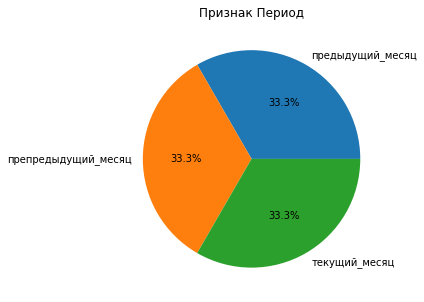

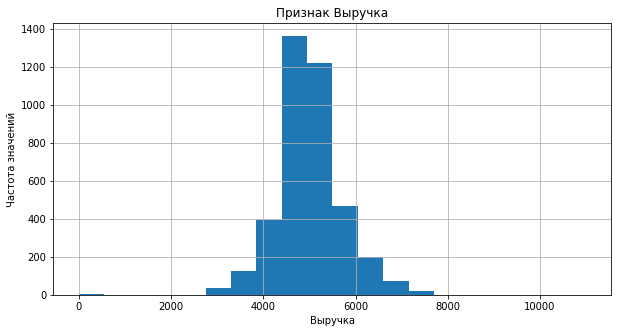

In [15]:
market_money.groupby('Период')['Период'].count().plot.pie(autopct='%1.1f%%')
plt.title('Признак Период')
plt.ylabel('')
plt.show() 

pd.Series(market_money['Выручка']).hist(bins=20, range=(0,11000))
plt.title('Признак Выручка')
plt.xlabel('Выручка')
plt.ylabel('Частота значений')
plt.show()  

Максимальное и минимальное значение выручки выходят за границы нормальных значений. Выведем "аномальные значения":

In [16]:
# сначала проверим пользователей, у которых в графе "Выручка" указано значение, меньше norm_min
market_money.query('Выручка < 1900')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Логично предположить, что это новые пользователи, поэтому данных о выручке за два предыдущих месяца нет.
В соответствии с ТЗ, ниже мы отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [17]:
# теперь проверим пользователей, у которых в графе "Выручка" указано значение, больше norm_max
market_money.query('Выручка > 8100')

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Посмотрим выручку по данному пользователю за другие периоды.

In [18]:
market_money.query('id == 215380')

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [19]:
market_file.query('id == 215380')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Тут два варианта: либо пользователь купил что-то оптом (что маловероятно, слишком большой разброс не только с его тратами за предыдущий период, но и с тратами других пользователей, при этом по данным из таблицы market_file его покупательская активность снизилась), либо в данные закралась опечатка.
Заполним это значение средним, по данному пользователю.

In [20]:
market_money.loc[(market_money['id'] == 215380) & (market_money['Выручка'] > 8100), 'Выручка'] = market_money.loc[(market_money['id'] == 215380) & (market_money['Выручка'] < 8100), 'Выручка'].mean()
market_money.query('id == 215380')

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,5564.0


### Анализ данных в таблице market_time

Построим графики для каждого признака. 
Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [21]:
market_time.describe()

info_market_time = market_time.drop(columns=['id']).describe().T
info_market_time['norm_min']=info_market_time['25%']-1.5*info_market_time['std']
info_market_time['norm_max']=info_market_time['75%']+1.5*info_market_time['std']
info_market_time

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
Минут,2600.0,13.336154,4.080198,4.0,10.0,13.0,16.0,23.0,3.879702,22.120298


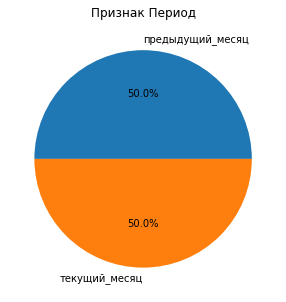

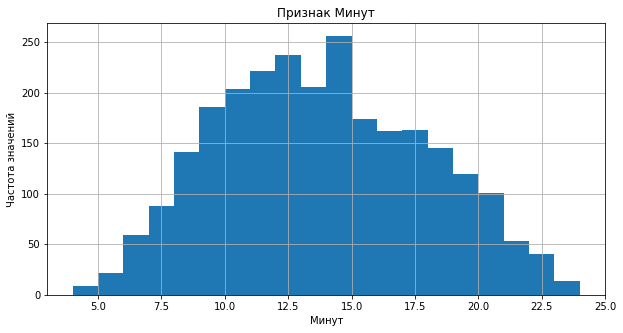

In [22]:
market_time.groupby('Период')['Период'].count().plot.pie(autopct='%1.1f%%')
plt.title('Признак Период')
plt.ylabel('')
plt.show() 

pd.Series(market_time['Минут']).hist(bins=20, range=(4,24))
plt.title('Признак Минут')
plt.xlabel('Минут')
plt.ylabel('Частота значений')
plt.show()  

Аномальных значений не выявлено, однако стоит отметить, что данные есть только за текущий и предыдущий месяц.

### Анализ данных в таблице money

Построим графики для каждого признака. 
Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [23]:
money.describe()

info_money = money.drop(columns=['id']).describe().T
info_money['norm_min']=info_money['25%']-1.5*info_money['std']
info_money['norm_max']=info_money['75%']+1.5*info_money['std']
info_money

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
Прибыль,1300.0,3.996631,1.013722,0.86,3.3,4.045,4.67,7.43,1.779417,6.190583


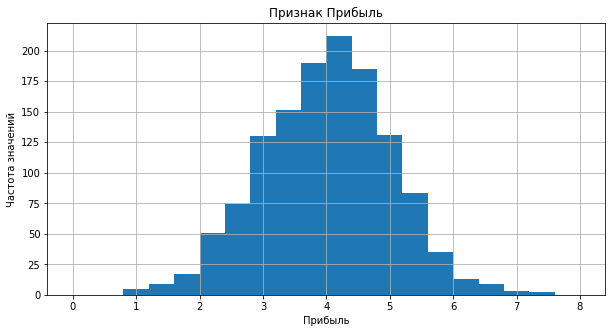

In [24]:
pd.Series(money['Прибыль']).hist(bins=20, range=(0,8))
plt.title('Признак Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Частота значений')
plt.show()  

Аномальных значений не выявлено.

### Отберем клиентов с покупательской активностью не менее трёх месяцев
В соответствии с ТЗ, отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
Соответственно, нам необходимо снова найти клиентов, у которых в столбце "Выручка" указан "0", и удалить клиентов с этим id.

In [25]:
market_money.query('Выручка == 0')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [26]:
market_file = market_file[~market_file['id'].isin(market_money.query('Выручка == 0')['id'])]
market_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

### Промежуточный вывод
На данном этапе выполнен исследовательский анализ данных, обработаны аномальные значения,а также отобраны клиенты с покупательской активностью не менее трёх месяцев. 

## Объединение таблиц

Объединим таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании нам не понадобятся. 
В итоговой таблице сделаем отдельный столбец для каждого периода.

In [27]:
# преобразуем таблицы market_money и market_time - сделаем отдельный столбец для каждого периода
money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка').reset_index()
time_pivot = market_time.pivot(index='id', columns='Период', values='Минут').reset_index()

# объединяем таблицы market_money и market_time с market_file по 'id'
merged_data = market_file.merge(money_pivot, on='id', how='left')
merged_data = merged_data.merge(time_pivot, on='id', how='left')

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

Переименуем столбцы.

In [28]:
merged_data.columns = merged_data.columns.str.replace('предыдущий_месяц_x', 'Выручка_предыдущий_месяц', regex=False)
merged_data.columns = merged_data.columns.str.replace('препредыдущий_месяц', 'Выручка_препредыдущий_месяц', regex=False)
merged_data.columns = merged_data.columns.str.replace('текущий_месяц_x', 'Выручка_текущий_месяц', regex=False)
merged_data.columns = merged_data.columns.str.replace('предыдущий_месяц_y', 'Время_предыдущий_месяц', regex=False)
merged_data.columns = merged_data.columns.str.replace('текущий_месяц_y', 'Время_текущий_месяц', regex=False)
merged_data.info()
merged_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


### Промежуточный вывод
На данном шаге мы объединили таблицы market_file, market_money, market_time, учитывая, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделали отдельный столбец для каждого периода.

## Корреляционный анализ

Рассчитаем коэффициенты корреляции Фи (так как нужно отобразить взаимосвязь между категориальными и интервальными признаками, а корреляция Пирсона не подходит для категориальных признаков).

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Время_предыдущий_месяц', 'Время_текущий_месяц']


<AxesSubplot:>

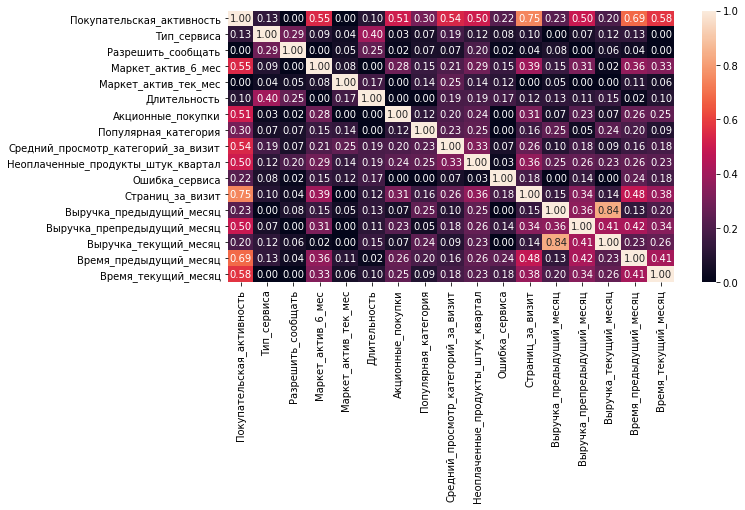

In [29]:
sns.heatmap(merged_data.drop(columns=['id']).phik_matrix(), annot=True, fmt='.2f')


### Промежуточный вывод
 - наибольший коэффициент корреляции между признаками "Выручка_предыдущий_месяц" и "Выручка_текущий_месяц", в этом есть логика, но удалять один из признаков не стоит, так как для обучения важно понимать динамику покупок по каждому клиенту
 - высокий коэффициент корреляции между признаками "Покупательская_активность" и "Страниц_за_визит", но недостаточно высокий для удаления признака из анализа, к тому же, совсем необязательно, что пользователь что-то купит, если посетил очень много страниц (знаю по себе :))

Посмотрим на распределения признаков в разрезе целевого признака (снижения активности).

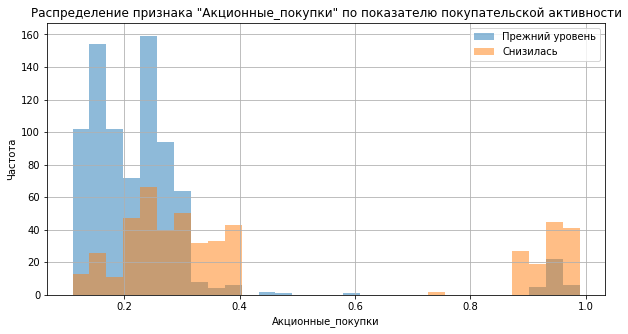

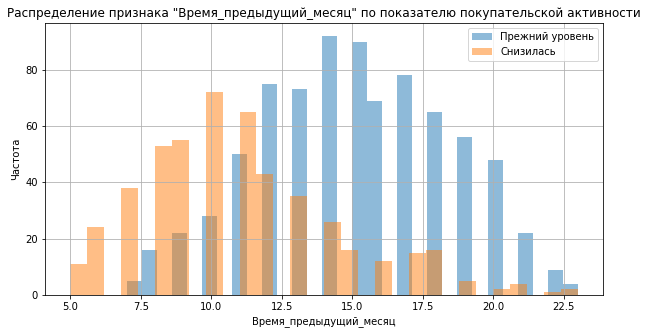

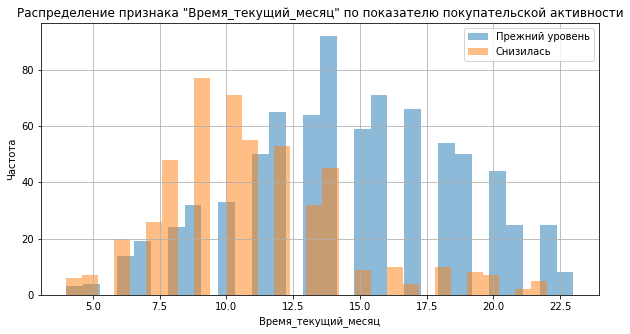

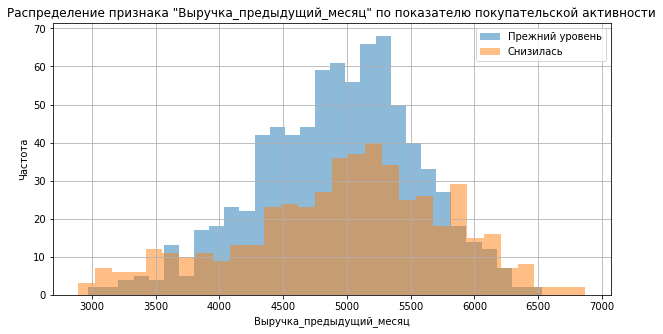

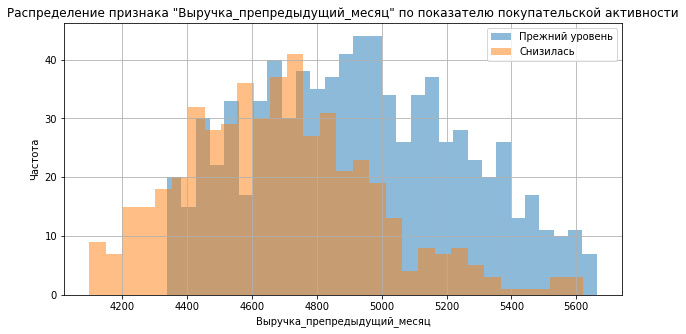

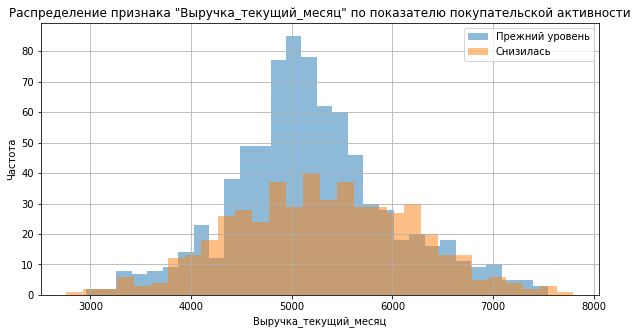

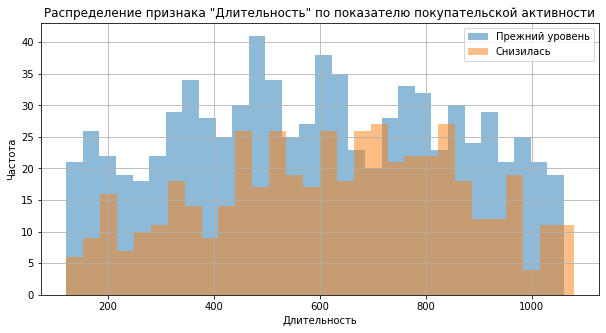

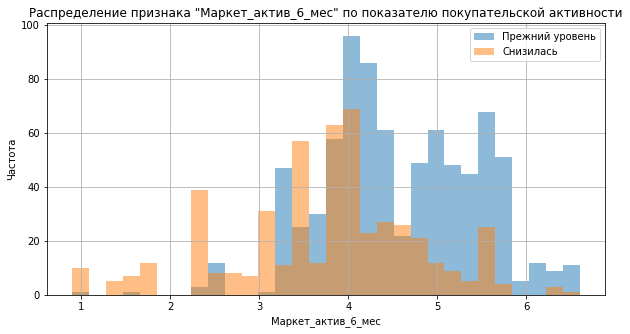

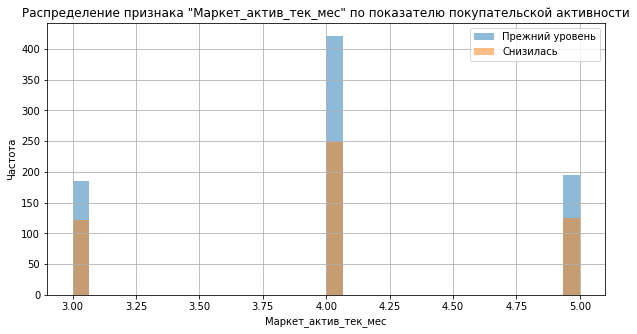

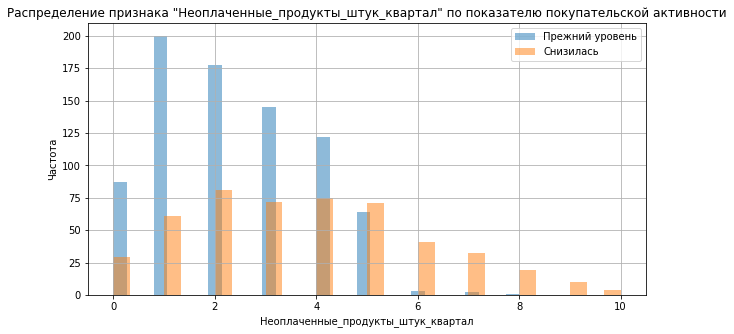

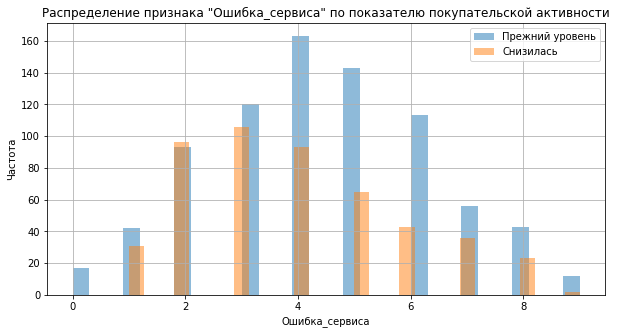

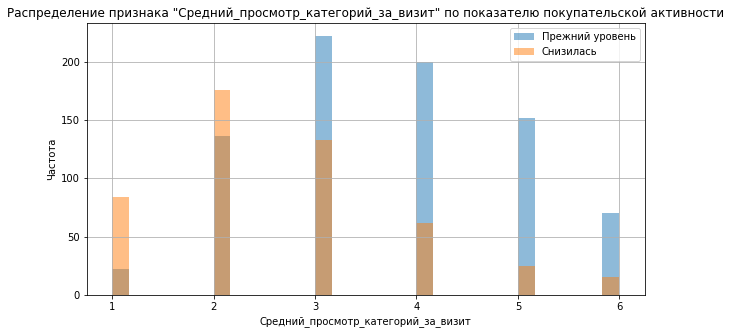

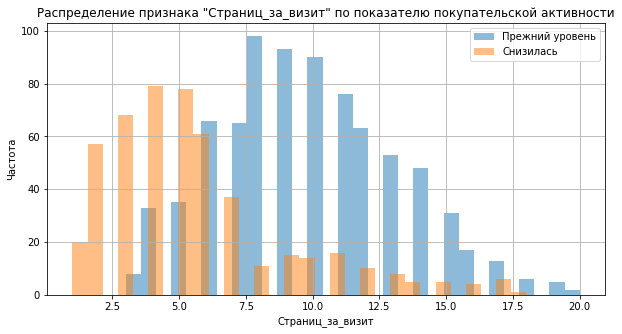

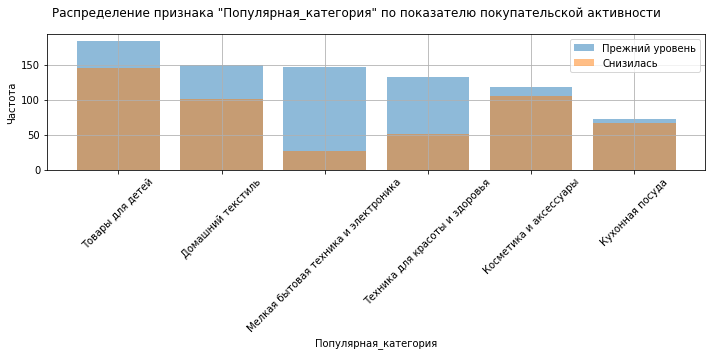

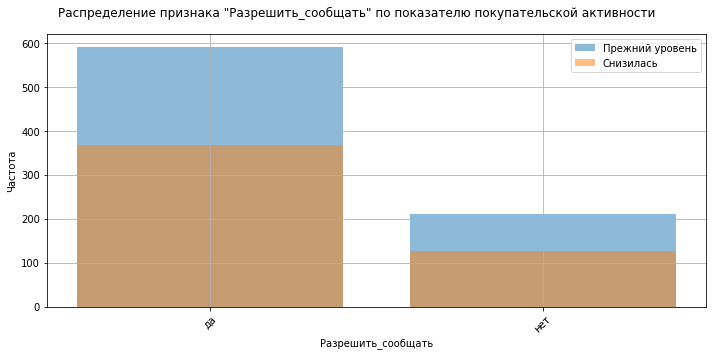

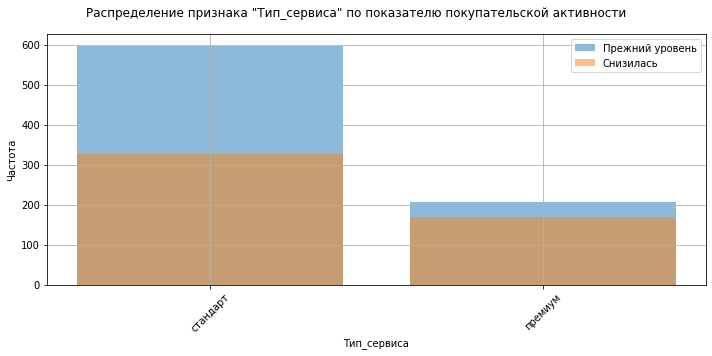

In [30]:
grouped_data = merged_data.groupby('Покупательская_активность')

# определяем количественные и категориальные признаки
numerical_features = merged_data.select_dtypes(include=['int64', 'float64']).columns.difference(['id'])
categorical_features = merged_data.select_dtypes(include=['object']).columns.difference(['Покупательская_активность'])

# для количественных данных
for column in numerical_features:
    for name, group in grouped_data:
        plt.hist(group[column], bins=30, alpha=0.5, label=name)
    plt.title(f'Распределение признака "{column}" по показателю покупательской активности')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.legend()
    plt.grid()
    plt.show()

# для категориальных данных
for column in categorical_features:
    for group_name, group in grouped_data:
        value_counts = group[column].value_counts()
        plt.bar(value_counts.index, value_counts, alpha=0.5, label=group_name if group_name not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.suptitle(f'Распределение признака "{column}" по показателю покупательской активности')
    plt.tight_layout()
    plt.show()


### Дополнение к промежуточному выводу

По построенным графикам можно сделать вывод, что пользователь, у которого снижается пользователская активность, меньше времени проводит времени на сайте и меньше страниц/категорий просматривает (группа "поведение на сайте" из ТЗ).

## Использование пайплайнов

In [31]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). 
Количественные и категориальные признаки обработаем в пайплайне раздельно. 
При подборе гиперпараметров будем использовать метрику F1, так как мы имеем дело с несбалансированным целевым признаком и классификацией с двоичным выходом (пользовательская активность либо снизилась, либо осталась прежней).

Выберем лучшую модель, используя заданную метрику.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    merged_data.drop(['id','Покупательская_активность'], axis=1),
    merged_data['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = merged_data['Покупательская_активность'])

# создаём списки с названиями признаков
ohe_columns = ['Тип_сервиса', 'Разрешить_сообщать']
ord_columns = ['Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 
               'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 
               'Выручка_текущий_месяц', 'Время_предыдущий_месяц', 'Время_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
                     'Кухонная посуда', 'Техника для красоты и здоровья', 
                     'Мелкая бытовая техника и электроника'], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__C': range(1,5),
        'models__kernel': ['linear', 'rbf', 'sigmoid'], 
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }

]

f1_scorer = make_scorer(f1_score, pos_label='Прежний уровень')

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    #scoring=f1_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверяем работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
#y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')
#print(f"F1 на тестовой выборке = {f1_score(y_test, y_test_pred, pos_label = 'Прежний уровень'):.2f}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                 

In [33]:
    print(f'Модель: {model_params["models"][0]}')
    print('Лучшие параметры:', search.best_params_)

NameError: name 'model_params' is not defined

### Промежуточный вывод
Получена лучшая модель (SVC) с лучшими гиперпараметрами (C=4).
НО по чату знаю, что должна была получиться другая модель (LogisticRegression).

## Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

In [ ]:
x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.KernelExplainer(randomized_search.best_estimator_.named_steps['models'].predict_proba, shap.sample(x_Train, 10))
x_Test = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names=pipe_final.named_steps['preprocessor'].get_feature_names_out()
x_Test = pd.DataFrame(x_Test, columns=feature_names)

shap_values = explainer(x_Test)[:, :, 1]
# Проверка размерности x_Test
print("Shape of x_Test:", x_Test.shape)
# Проверка размерности shap_values
print("Shape of shap_values:", shap_values.shape)

shap.summary_plot(shap_values, x_Test, plot_type="bar", feature_names=feature_names)


### Промежуточный вывод
Наиболее "влиятельные" признаки - это "Акционные_покупки" и "Популярная категория".

## Сегментация покупателей

Выполним сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей.

Добавим в таблицу два столбца:

 - вероятность снижения активности
 - прибыль из таблицы money

In [ ]:
merged_data['Прогноз_снижения_активности']=randomized_search.predict_proba(merged_data.drop(['id','Покупательская_активность'], axis=1))[:, 1]
final_data = merged_data.merge(money, on='id', how='left')
final_data.head()

In [ ]:
plt.scatter(final_data['Прогноз_снижения_активности'], final_data['Прибыль'], alpha=0.5)
plt.title('Скаттерплот: Прогноз vs Прибыль')
plt.xlabel('Прогноз снижения активности')
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

В п.4.4, анализируя данные таблицы money, были получены следующие данные:

In [ ]:
display(info_money)

pd.Series(money['Прибыль']).hist(bins=20, range=(0,8))
plt.title('Признак Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Частота значений')
plt.show()  

Предлагаю разбить клиентов на категории по прибыли:
 - низкая прибыль - ниже значения norm_min
 - средний уровень - от norm_min до mean
 - выше среднего - более mean
 
При этом бизнесу "интересны" клиенты со средним и выше среднего уровня прибыли, для которых модель предсказала снижение прибыли в ближайшие 3 месяца (чтобы не допустить снижения прибыли).

Исходя из этих двух графиков, считаю необходимым изучить клиентов с выручкой более 2 и вероятностью снижения более 0.85.

In [ ]:
segment_data=final_data.query('Прибыль>2 & Прогноз_снижения_активности>0.85')
segment_data.info()

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Отлично.
</div>

Как мы выяснили в п.8 при анализе важности признаков - наиболее "влиятельные" признаки - это "Акционные_покупки" и "Популярная категория". Построим для них диаграммы.
При этом мы выяснили в п.6 при проведении анализа данных мы выявили, что пользователь, у которого снижается пользователская активность, меньше времени проводит времени на сайте и меньше страниц/категорий просматривает (группа "поведение на сайте" из ТЗ). Также построим график в части акционных покупок.

In [ ]:
segment_data.groupby('Популярная_категория')['Популярная_категория'].count().plot.pie(autopct='%1.1f%%')
plt.title(f'Признак Популярная_категория')
plt.ylabel('')
plt.show() 

pd.Series(segment_data['Акционные_покупки']).hist()
plt.title(f'Признак Акционные_покупки')
plt.xlabel('Процент акционных покупок')
plt.ylabel('Частота значений')
plt.show()  



### Промежуточный вывод
Соответственно, я бы предложила среди пользователей выделенного сегмента выявить наиболее популярные категории и выдавать более точные для них рекомендации покупок на сайте (вероятно, их активность на сайте снижается именно потому, что им неинтересны выдаваемые в рекомендациях товары), а также добавить дополнительные акции на выбранные категории (товары для детей, косметика и аксессуары, домашний текстиль).

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
    
Попыталась исправить. Огромное спасибо за подсказки!
</div>

## Итоговый вывод


В данном проекте были проанализированы данные интернет-магазина «В один клик», который продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. 

Нам были представлены хорошие, практически "чистые" данные: не было нулевых значений, не потребовалась также изменять форматы данных, лишь выявлены и устранены опечатки в значениях, а также изменены названия столбцов.

На этапе исследовательского анализа данных обработаны аномальные значения, а также отобраны клиенты с покупательской активностью не менее трёх месяцев.

В рамках проекта составлен "портрет" пользователя, чья активность снизилась в последнее время: он меньше времени проводит на сайте и меньше страниц/категорий просматривает (группа "поведение на сайте" из ТЗ).

Подобрана и построена лучшая модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

В исследование включены дополнительные данные финансового департамента о прибыльности клиента.

Используя данные модели и данные о прибыльности клиентов, предлагается среди пользователей выделенного сегмента (клиентов с выручкой более 2 и вероятностью снижения пользовательской активности более 0.85) выявить наиболее популярные категории и выдавать более точные для них рекомендации покупок на сайте (вероятно, их активность на сайте снижается именно потому, что им неинтересны выдаваемые в рекомендациях товары), а также добавить дополнительные акции на выбранные категории (товары для детей, косметика и аксессуары, домашний текстиль).